In [25]:
from datasets import load_from_disk
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch import nn
import torch

from torchaudio.utils import download_asset

from IPython.display import Audio

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Data

In [3]:
!pip install librosa soundfile>=0.12.1

In [27]:
DATA_PATH = '../data/train/'
SAMPLE_RATE = 48000

data = load_from_disk(DATA_PATH)
train_data = DataLoader(data)

In [ ]:
next(iter(train_data))

In [28]:
audio = next(iter(train_data))['audio']
# audio_file = download_asset()
DATA_PATH + audio['path'][0]

'../data/train/common_voice_ru_22070781.mp3'

In [35]:
len(train_data)

26269

In [36]:
lengths = np.zeros(len(train_data))
for i, batch in enumerate(tqdm(train_data)):
    lengths[i] = batch['audio']['array'][0].shape[0] / SAMPLE_RATE

100%|██████████| 26269/26269 [01:42<00:00, 255.39it/s]


(array([  3.,   3.,   3.,   2.,   4.,  11.,  34.,  63.,  40., 109.,  77.,
        174., 152., 187., 262., 314., 253., 358., 332., 431., 487., 335.,
        504., 531., 360., 595., 379., 504., 550., 392., 569., 466., 471.,
        419., 505., 454., 529., 479., 545., 593., 453., 487., 409., 541.,
        579., 402., 457., 539., 373., 518., 338., 490., 383., 451., 379.,
        396., 343., 401., 356., 394., 339., 283., 338., 333., 280., 279.,
        195., 286., 260., 157., 235., 174., 193., 166., 143., 146., 127.,
         98., 152.,  91.,  77.,  81.,  87.,  54.,  89.,  56.,  58.,  53.,
         31.,  43.,  28.,  33.,  22.,  16.,  24.,  21.,  19.,  19.,   6.,
          9.]),
 array([ 1.08   ,  1.17456,  1.26912,  1.36368,  1.45824,  1.5528 ,
         1.64736,  1.74192,  1.83648,  1.93104,  2.0256 ,  2.12016,
         2.21472,  2.30928,  2.40384,  2.4984 ,  2.59296,  2.68752,
         2.78208,  2.87664,  2.9712 ,  3.06576,  3.16032,  3.25488,
         3.34944,  3.444  ,  3.53856,  3.63312

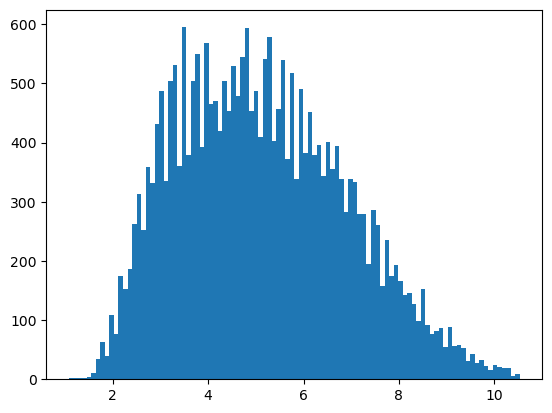

In [38]:
plt.hist(lengths, bins = 100)

In [31]:
audio['array'][0].shape[0] / SAMPLE_RATE

4.224

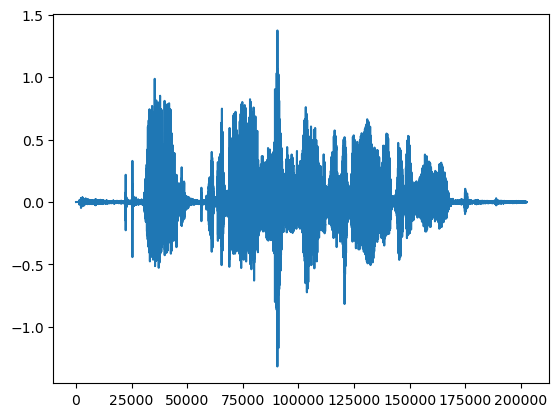

In [17]:
plt.plot(audio.flatten())

# VAE

In [ ]:
class VAE2d(nn.Module):
    def __init__(self, n_in, n_latent, enc_hidden_sizes, dec_hidden_sizes):
        assert isinstance(enc_hidden_sizes, list)
        assert isinstance(dec_hidden_sizes, list)
        super().__init__()
        self.n_latent = n_latent

        # ====
        # your code
        # define encoder and decoder networks
        # the encoder takes n_in elements, has enc_hidden_sizes neurons in hidden layers 
        # and outputs 2 * n_latent (n_latent for means, and n_latent for std)
        # the decoder takes n_latent elements, has dec_hidden_sizes neurons in hidden layers 
        # and outputs 2 * n_in (n_in for means, and n_in for std)
        # ====
        self.encoder = FullyConnectedMLP(n_in    , enc_hidden_sizes, 2 * n_latent )
        self.decoder = FullyConnectedMLP(n_latent, dec_hidden_sizes, 2 * n_in     )
    def prior(self, n):
        # ====
        # your code
        # return n samples from prior distribution (we use standard normal for prior)
        # ====
        loc   = torch.zeros(self.n_latent)
        scale = torch.ones (self.n_latent)
        p = torch.distributions.Normal(loc, scale)
        prior_s = p.sample_n(n)

        if USE_CUDA:
            prior_s = prior_s.cuda()
        return prior_s

    def forward(self, x):
        # ====
        # your code
        # now you have to return from the model 
        # - mu_z - means for variational distribution 
        # - mu_x - means for generative distribution
        # - log_std_z - logarithm of std for variational distribution
        # - log_std_x - logarithm of std for generative distribution
        # we use logarithm, since the std is always positive
        # to get std we will exponentiate it to get rid of this constraint

        # 1) mu_z, log_std_z are outputs from the encoder
        # 2) apply reparametrization trick to get z (input of decoder)
        # (do not forget to use self.prior())
        # 3) mu_x, log_std_x are outputs from the decoder
        #    Note: [mu, log_std = decoder(input).chunk(2, dim=1)]
        
        # ====
        mu_z, log_std_z = self.encoder(x).chunk(2, dim=1)
        z = torch.exp(log_std_z.to('cuda'))*self.prior( x.size(0) ) + mu_z.to('cuda')
        mu_x, log_std_x = self.decoder(z).chunk(2, dim=1)
        
        return mu_z, log_std_z, mu_x, log_std_x

    def loss(self, x):
        mu_z, log_std_z, mu_x, log_std_x = self(x)
        # ====
        # your code
        # 1) apply model to get mu_z, log_std_z, mu_x, log_std_x
        # 2) compute reconstruction loss using get_normal_nll (it is the first term in ELBO)
        # 3) compute KL loss using get_normal_KL (it is the second term in ELBO)
        # ====
        recon_loss = torch.sum(get_normal_nll( x, mu_x, log_std_x ))
        #kl_loss    = torch.sum(get_normal_KL ( mu_z, log_std_z, mu_x, log_std_x ))
        kl_loss    = torch.sum(get_normal_KL ( mu_z, log_std_z, torch.zeros_like(mu_z), torch.zeros_like(log_std_z) ))


        return {
            'elbo_loss': recon_loss + kl_loss, 
            'recon_loss': recon_loss,
            'kl_loss': kl_loss
        }

    def sample(self, n, sample_from_decoder=True):
        z = None
        with torch.no_grad():
            # ====
            # your code
            # to sample from VAE model you have to sample from prior
            # and then apply decoder to prior samples.
            # parameter noise indicates whether to sample from decoder
            # or just use means of generative distribution as samples
            # 1) generate prior samples
            # 2) apply decoder
            # 3) sample from the decoder distribution if sample_from_decoder=True
            # ====
            prior_s = self.prior(n)
            mu_x, log_std_x = self.decoder(prior_s).chunk(2, dim=1)
            if sample_from_decoder:
                z = torch.exp(log_std_x)*prior_s + mu_x
            else:
                z = mu_x
        return z.cpu().numpy()